# Future scenario S/N ratio analysis

In [ ]:
!mamba install -y --file /home/jovyan/pangeo/code/requirements.txt

In [ ]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
#import esmvalcore.preprocessor as ecpr
#import pymannkendall as mkt
import pandas as pd

%matplotlib inline

In [ ]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

# there is currently a significant amount of data for these runs
expts_full = ['historical','ssp126', 'ssp245', 'ssp370', 'ssp585', 'piControl']

query = dict(
    #activity_id = 'DAMIP',
    experiment_id=expts_full,
    table_id='Amon',                           
    variable_id=['tas', 'pr', 'ua', 'va'],
    member_id = 'r1i1p1f1',                     
)

col_subset = col.search(require_all_on='source_id', **query)
#col_subset.df = col_subset.df[col_subset.df['source_id'] != 'FGOALS-f3-L']
col_subset_var = [col_subset.search(variable_id=var_name) for var_name in query['variable_id']]
print(f'Number of models found: {col_subset.df.source_id.nunique()}')

In [ ]:
col_subset

In [ ]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    #assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True, decode_times=True, use_cftime=True)
    if 'plev' in ds.coords:
        for lev in ds.plev.values:
            if int(lev)==85000:
                ind = np.where(ds.plev.values==lev)
                break
        ds = ds.isel(plev=ind[0]).drop('plev')
        #ds.drop('plev')
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = []
for col_subset in col_subset_var :
    dset = defaultdict(dict)

    for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
        dset[group[0]][group[1]] = open_delayed(df)
    dsets.append(dset)
len(dsets)

In [ ]:
with progress.ProgressBar():
    dsets_ = dask.compute(dict(dsets[1]))[0]

In [ ]:
dset_dict = col_subset_var[1].to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)

In [ ]:
ss = [key for key in dset_dict.keys()]
dset_dict[ss[10]]

In [ ]:
import pymannkendall as mkt
import esmvalcore.preprocessor as ecpr
import dask.array as da
import iris
import itertools
import xesmf as xe
def get_vname(ds):
    #print(ds.variables)
    for v_name in ds.variables.keys():
        #print(v_name)
        if v_name in ['pr', 'ua', 'va']:
            return v_name
    raise RuntimeError("Couldn't find a variable")
            
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")
    
def get_lon_name(ds):
    for lon_name in ['lon', 'longitude']:
        if lon_name in ds.coords:
            return lon_name
    raise RuntimeError("Couldn't find a longitude coordinate")

def regrid(ds):
    var_name = get_vname(ds)
    lat_name = get_lat_name(ds)
    lon_name = get_lon_name(ds)
    
    ds_out = xr.Dataset({
        lat_name: ([lat_name], np.arange(-90, 90, 1.0)),
        lon_name: ([lon_name], np.arange(-180, 180, 1.0)),
    })
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    ds_reg = regridder(ds)#.to_dataset(name=var_name)
    ds_reg = ds_reg.sel({lat_name:slice(-40, 40), lon_name:slice(5,120)})
    return ds_reg


def jjas_mean(ds):
    #print(ds)
    var_name = get_vname(ds)
    lat_name = get_lat_name(ds)
    lon_name = get_lon_name(ds)
    mind = ds.groupby('time.month')
    mind_sel = mind.groups[6] + mind.groups[7] + mind.groups[8] + mind.groups[9] 
    ds_sel = ds[var_name][mind_sel].groupby('time.year').mean().to_dataset(name=var_name)
    #print(ds_sel)
    return ds_sel

In [ ]:
from toolz.functoolz import juxt
expt_norm = expts_full[:-1]
expt_da = xr.DataArray(expt_norm, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expt_norm})

dsets_aligned_list = []

##selecting variable 'pr' only
dset_= dsets_

j=0
dsets_aligned = {}
for k, v in tqdm(dset_.items()):
    #print(k)
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_jjas_mean = []
    for expt in expt_norm:
        ds = v[expt].pipe(regrid).pipe(jjas_mean)
        if expt == 'historical':
            ds = ds.sel(year=slice(1950,2014))
        dsets_jjas_mean.append(ds)

    # align everything with the 4xCO2 experiment

    dsets_aligned[k] = xr.concat(dsets_jjas_mean, join='outer',
                                dim=expt_da)
dsets_aligned_list.append(dsets_aligned)

In [ ]:
with progress.ProgressBar():
    dsets_aligned_list_ = dask.compute(dsets_aligned_list[0])[0]

In [ ]:
source_ids = list(dsets_aligned_list_.keys())

In [ ]:
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})
big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_list_.values()],
                    dim=source_da)

## S/N ratio analysis
focus on two future periods one up to the 2050s 

    -  2025 to 2055, and
    -  2069 to 2099. 
    - Do the analysis focusing on Asian summer monsoon rainfall (also using MME but better to check for model spread) 
    and for different scenario SSPs 1-1.9, 2-4.5, 3-7.0, and 5-8.5. 
    
    - What would be the signal to noise ratio (MME future change/ Inter model SD) 

In [ ]:
big_ds = big_ds*86400
hist_data = big_ds.sel({'experiment_id':'historical', 'year':slice(1985,2014),}).mean('year')
hist_data


In [ ]:
near_future = big_ds.sel(experiment_id=(big_ds.experiment_id != 'historical'), year=slice(2025, 2055))
nf_mean = near_future.mean('year')
nf_mean

In [ ]:
far_future = big_ds.sel(experiment_id=(big_ds.experiment_id != 'historical'), year=slice(2069, 2099))
ff_mean = far_future.mean('year')
ff_mean

In [ ]:
nf_change = nf_mean - hist_data
nf_change

In [ ]:
ff_change = ff_mean - hist_data
ff_change

In [ ]:
nf_ens = nf_change.mean('source_id')
nf_std = nf_change.std('source_id')
nf_std

In [ ]:
ff_ens = ff_change.mean('source_id')
ff_std = ff_change.std('source_id')
ff_std

In [ ]:
nf_sn = nf_ens/nf_std
nf_sn.pr.plot(col='experiment_id', vmin=-5, vmax=5, cmap='seismic')

In [ ]:
ff_sn = ff_ens / ff_std
#ff_sn.pr.plot(col='experiment_id', cmap='rainbow', vmin=-2, vmax=2)
ff_sn.pr.plot(col='experiment_id', vmin=-5, vmax=5, cmap='seismic')

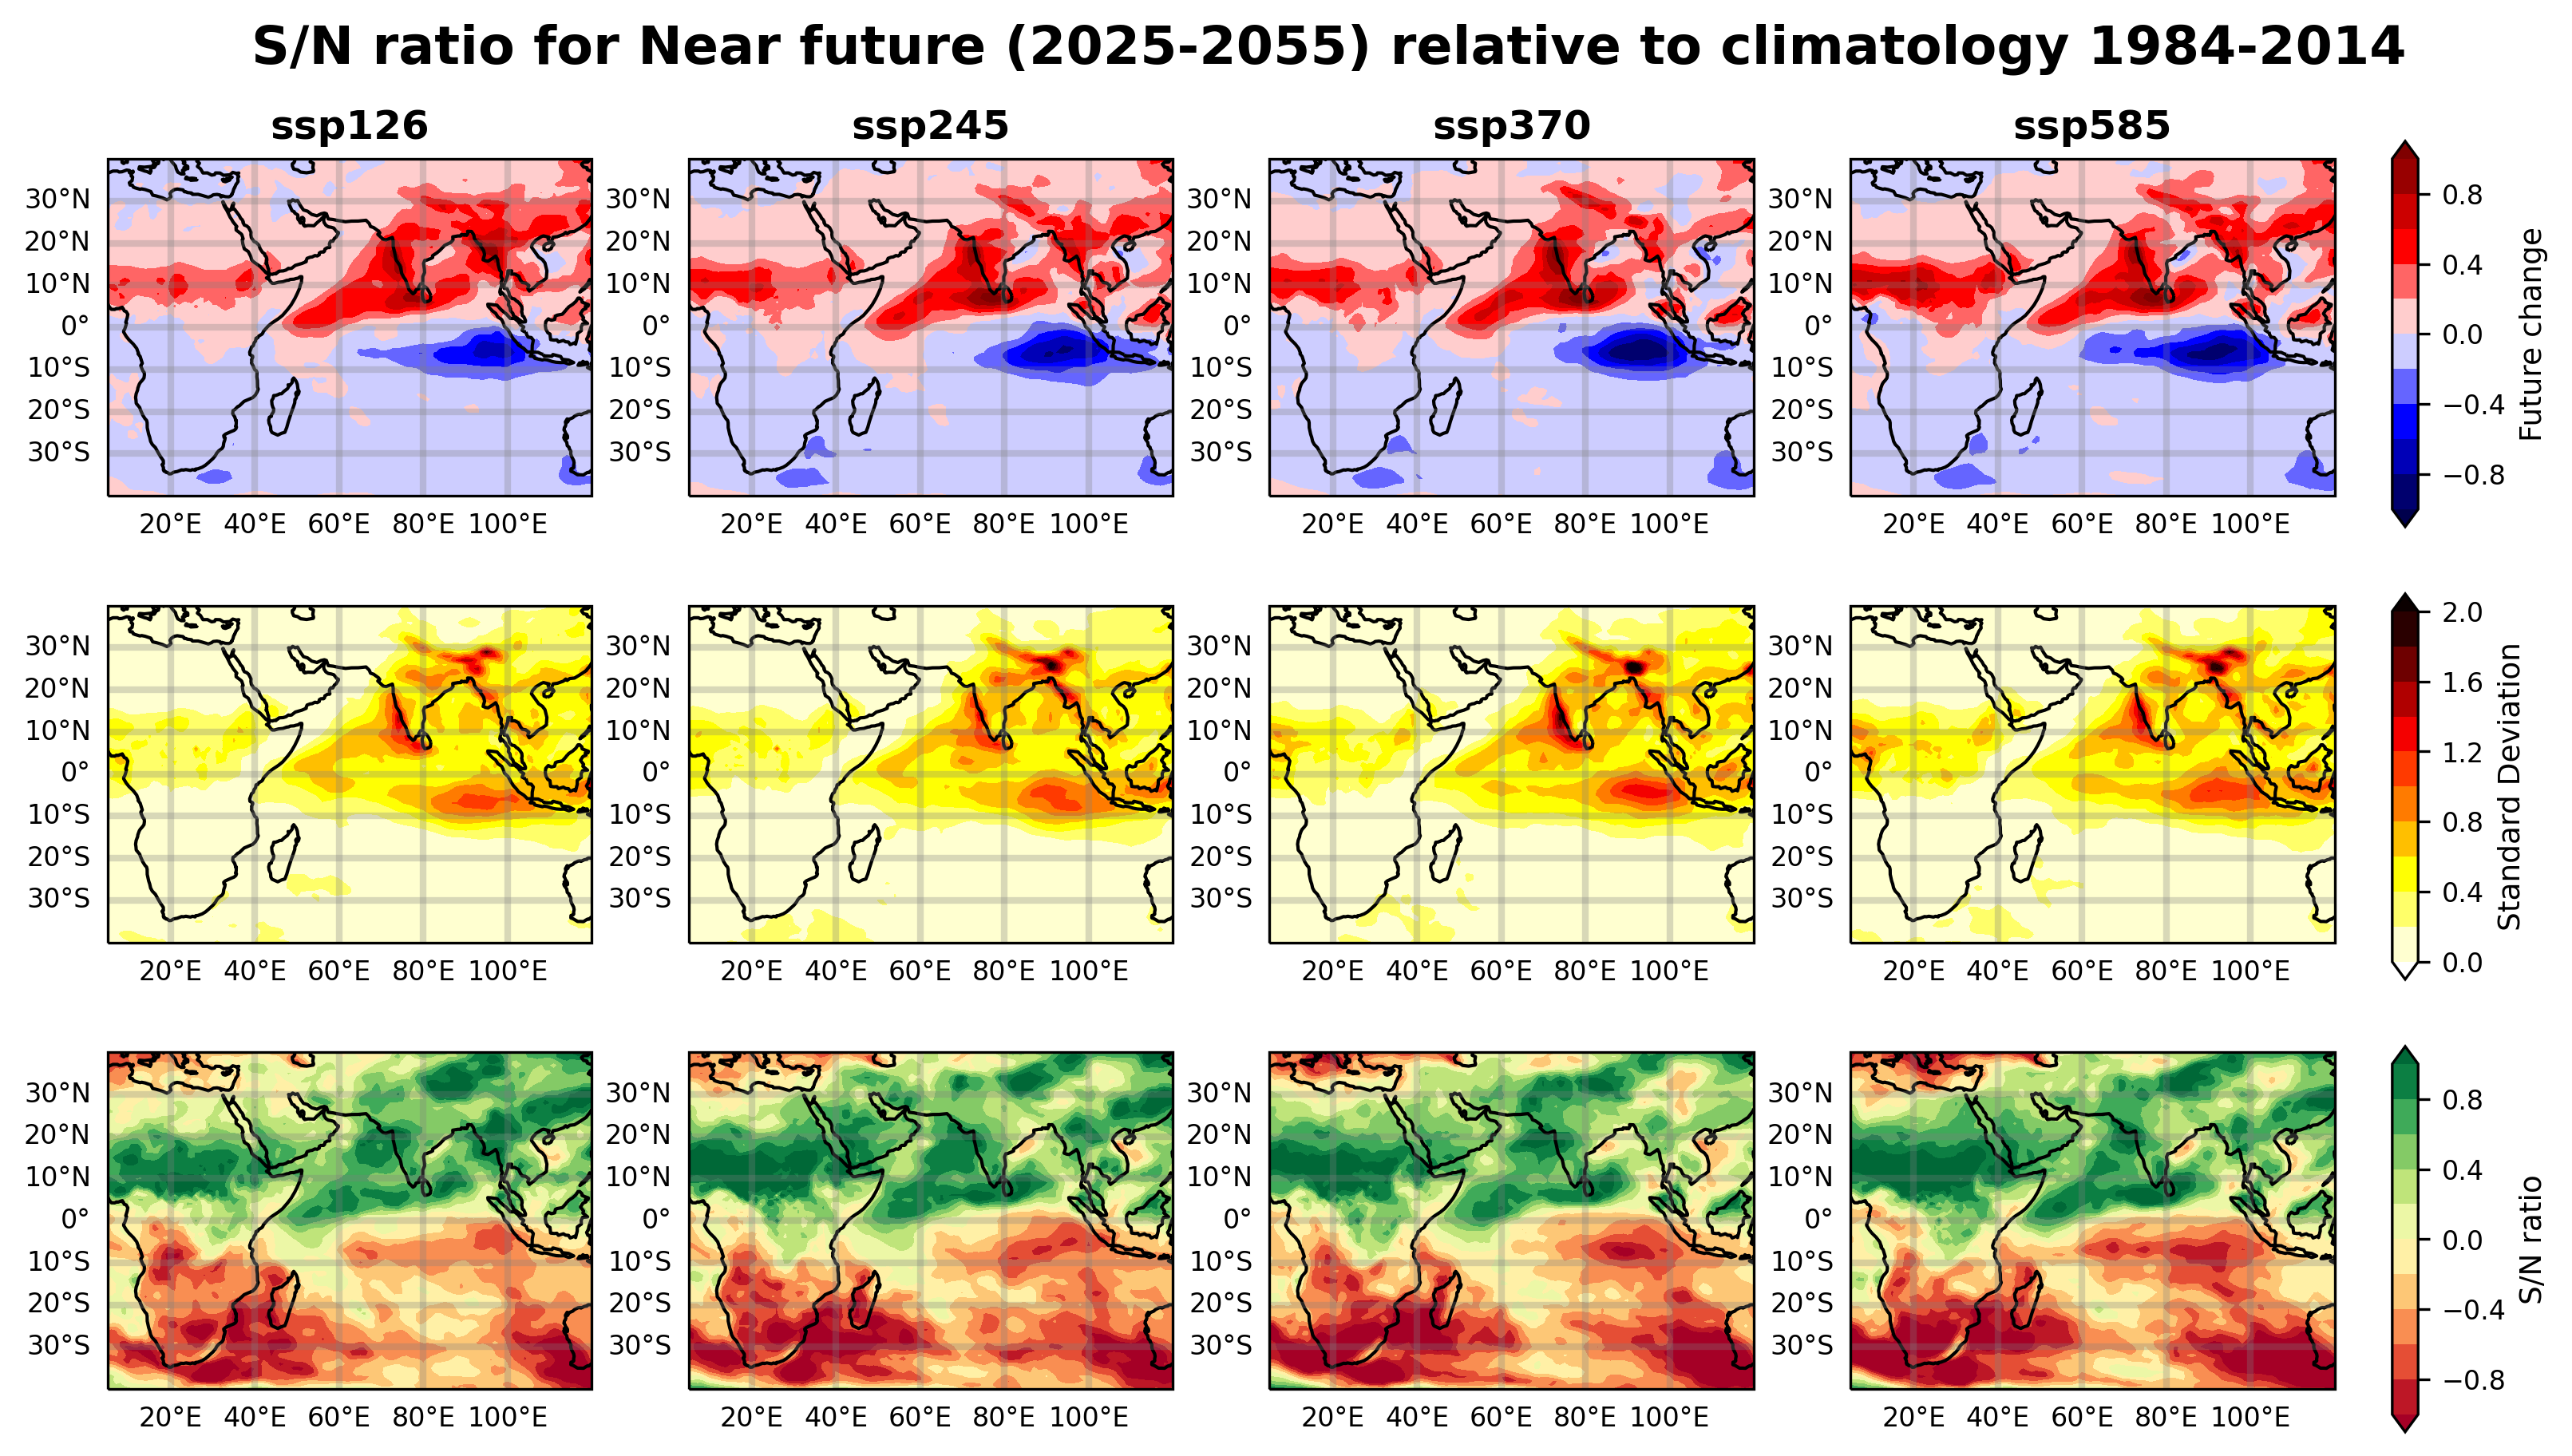

In [101]:
import matplotlib.pyplot as plt
from cartopy import feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib.colorbar as clb
import itertools

change_arr = [nf_ens, ff_ens]
sd_arr = [nf_std, ff_std]
snr_arr = [nf_sn, ff_sn]

nrow = 3
ncol = 4


k=0
arrs = [change_arr[k], sd_arr[k], snr_arr[k]]
cbar_title = ['Future change', 'Standard Deviation', 'S/N ratio']
sup_title = ["S/N ratio for Near future (2025-2055) relative to climatology 1984-2014", 
             "S/N ratio for Far future (2069-2099) relative to climatology 1984-2014" ]
cmaps = ['seismic', 'hot_r', 'RdYlGn']

ff_lim = [np.linspace(-2, 2, 11), np.linspace(0, 3, 16), np.linspace(-1.4, 1.4, 9)]
nf_lim = [np.linspace(-1, 1, 11), np.linspace(0, 2, 11), np.linspace(-1, 1, 11)]
lim_arr = [nf_lim, ff_lim]

cbar_y = 0.65
fig, axs = plt.subplots(nrow, ncol, dpi=300, 
                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                        figsize= (12,7))
fig.suptitle(sup_title[k], x=0.55, y=0.95, fontsize=16, weight='bold')

for i in range(nrow):
    data = arrs[i]
    X,Y = np.meshgrid(data.lon, data.lat)
    for j in range(ncol):
        ax = axs[i,j]
        ax.coastlines()
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='grey', 
                          alpha=0.3, linestyle='-', draw_labels=True)
        fs=8
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': fs}
        gl.ylabel_style = {'size': fs}
        
        pc = ax.contourf(X, Y, data.pr.isel(experiment_id=j), cmap=cmaps[i], extend='both', levels=lim_arr[k][i])
        bbox = [10,120,-20,40]
        #ax.set_extent(bbox,crs=ccrs.PlateCarree())
        if i==0:
            ax.set_title(data.experiment_id.isel(experiment_id=j).values, fontsize=12, weight='bold')
    
    clb_ax_params = [0.92, cbar_y, 0.009, 0.23]
    cbar_y = cbar_y - 0.27
    cbar_ax = fig.add_axes(clb_ax_params)
    cb = fig.colorbar(pc, cax=cbar_ax, orientation='vertical')
    cb.ax.tick_params(labelsize=8)
    cbar_ax.set_ylabel(cbar_title[i], size=9)
    
path = ['/home/jovyan/pangeo/plot/near_future_stats.png', '/home/jovyan/pangeo/plot/far_future_stats.png']
plt.savefig(path[k], bbox_inches='tight', facecolor='w')

In [ ]:
data